# Assignment 2

## Learning Goals

After successfully completing this assignment, you should: 

* be able to learn a linear hypothesis to predict labels of **datapoints** 

* be able to learn a polynomial hypothesis to predict labels of **datapoints** 

* understand the effect of enlarging the **model** on the resulting **training error**

* understand the effect of enlarging the **training set** on the resulting **training error**

* understand the effect of using different **loss** functions on the robustness against **outliers**


## General Instruction
- Jupyter notebook is supposed to be run cell by cell in order, please do not skip any code cell, this will cause some errors. Also running cells back and forth sometimes might also incur errors. If you feel lost your track, you can click "Kernel->Restart" from the menu to restart the process.
- Please do NOT change the metadata of any cell, cells for demo and instructions are not editable.
- You can copy lines of code from cells that are not editable, but please do NOT copy and paste them as cells, this may incur validation error. 
- You can add extra cells or code to help double-check your solution, but please make sure that variables required by tasks are not overwritten, or just delete those extra cells before submitting.
- Remember that demos in previous assignments may also be helpful to solve tasks in the present notebook.


In [3]:
%config Completer.use_jedi = False  # enable code auto-completion
import numpy as np    # library for numerical computations (vectors, matrices, tensors)
import pandas as pd    # library for data manipulation and analysis
import matplotlib.pyplot as plt    # library providing tools for plotting data
from sklearn.preprocessing import PolynomialFeatures    # function to generate polynomial and interaction features
from sklearn.linear_model import LinearRegression, HuberRegressor    # classes providing Linear Regression with ordinary squared error loss and Huber loss, respectively
from sklearn.metrics import mean_squared_error    # function to calculate mean squared error 

<div class=" alert alert-warning">

# Student Task A2.1

Consider datapoints that represent the daily weather conditions at some place in Finland. We can characterize these datapoints using weather recordings from the [Finnish Meteorological Institute](https://en.ilmatieteenlaitos.fi/). For your convenience we have already downloaded and stored these recordings in the csv file `FMIData_Assignment2.csv`. This task requires you to first read in the weather recordings from this file and store them in a `pandas` dataframe with the name `FMIRawData`. 
    
Each row of dataframe `FMIRawData` contains a weather recording along with a time-stamp. We will use for each datapoint the weather recording with time-stamp `00:00`. For the $i$th day, we use the value in the column "Minimum temperature" as the feature $x^{(i)}$ and the value in the column "Maximum temperature" as the label $y^{(i)}$. You then have to collect the feature values in a two-dimensional numpy array `X` of shape `(m,1)` with `m` being the number of different datapoints (days) listed in `FMIData_Assignment2.csv`. Similarly, you have to collect the label values $y^{(i)}$, for $i=1,\ldots,m$ in a one-dimensional numpy array `y` of shape `(m)` (which is sometimes written as `(m,)`). 
</div>

<div class=" alert alert-warning">

As the very first step you need to use `pd.read_csv()` to load the weather recordings stored in the file `FMIData_Assignment2.csv` into a `pandas` dataframe `FMIRawData`.
</div>

In [4]:
## read in the data stored in the file 'FMIData_Assignment2.csv'

# FMIRawData = ...

# YOUR CODE HERE
FMIRawData = pd.read_csv("FMIData_Assignment2.csv")

# sanity check the shape of FMIRawData
assert FMIRawData.shape == (1418,11)

# print the first 5 rows of the DataFrame 'FMIRawData'
FMIRawData.head(5)  

,Year,m,d,Time,Time zone,Precipitation amount (mm),Snow depth (cm),Air temperature (degC),Ground minimum temperature (degC),Maximum temperature (degC),Minimum temperature (degC)
0,2020,1,1,00:00,UTC,0.0,-1.0,1.5,NaN,3.4,-2.6
1,2020,1,1,06:00,UTC,NaN,NaN,NaN,-5.7,NaN,NaN
2,2020,1,2,00:00,UTC,-1.0,-1.0,3.6,NaN,5.1,1.8
3,2020,1,2,06:00,UTC,NaN,NaN,NaN,0.1,NaN,NaN
4,2020,1,3,00:00,UTC,1.2,-1.0,4.6,NaN,5.7,4.3


In [5]:
# print the column names
FMIRawData.columns

Index(['Year', 'm', 'd', 'Time', 'Time zone', 'Precipitation amount (mm)',
       'Snow depth (cm)', 'Air temperature (degC)',
       'Ground minimum temperature (degC)', 'Maximum temperature (degC)',
       'Minimum temperature (degC)'],
      dtype='object')

In [6]:
## execute some operations to make the dataframe layout tidy

# remove columns 'Time zone', 'Precipitation amount (mm)','Snow depth (cm)' that are not used 
# and return a new dataframe "data"
data = FMIRawData.drop(['Time zone', 'Precipitation amount (mm)','Snow depth (cm)'],axis=1)

# change column names
data.columns=['Year','Month', 'Day', 'Time', 'AirTemp','GroundMinTmp','MaxTemp','MinTemp'] 

# concatenate the 3 columns "Year", "Month", "Day" into a new column "Date" in format e.g. 2022-01-26
date_column = data["Year"].astype(str)+'-'+data["Month"].astype(str)+'-'+data["Day"].astype(str)
data.insert(0,"Date",date_column)

# drop useless columns NOTE: set inplace=True to do the operation inplace instead of retrun a new dataframe
data.drop(['Year','Month','Day'],axis=1,inplace=True)

data.head()

,Date,Time,AirTemp,GroundMinTmp,MaxTemp,MinTemp
0,2020-1-1,00:00,1.5,NaN,3.4,-2.6
1,2020-1-1,06:00,NaN,-5.7,NaN,NaN
2,2020-1-2,00:00,3.6,NaN,5.1,1.8
3,2020-1-2,06:00,NaN,0.1,NaN,NaN
4,2020-1-3,00:00,4.6,NaN,5.7,4.3


<div class=" alert alert-warning">


We next select only rows with time-stamp `"00:00"` and then select the values from relevant columns to build the feature matrix and label vector. 
Hints: 

- Select only weather recordings whose property `Time` is equal to `"00:00"` to create a new dataframe `newdata`.
  Here is a tutorial for how to select rows from pandas dataframe based on column values: [link](https://towardsdatascience.com/how-to-select-rows-from-pandas-dataframe-based-on-column-values-d3f5da421e93).

- Select the column `MinTemp` of the DataFrame `newdata` as features `X`(using capital x to denote a feature matrix is a convention) and `MaxTemp` as labels `y`. You can checkout this link to see more details about [how to select columns based on column names.](https://pandas.pydata.org/docs/getting_started/intro_tutorials/03_subset_data.html)
- Use the `Series.to_numpy()`method to convert the selected column to a NumPy array for both `X` and `y`.
- Reshape `X` into a 2D array by using array.reshape(-1, 1). This asks numpy to make the second dimension length one and automatically calculate the needed length of the first dimension so that the feature fits in the container which expects a 2D array. (For more details, please check the documentation of .fit() method of [LinearRegression](https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LinearRegression.html#sklearn.linear_model.LinearRegression.fit)).
</div>

In [7]:
## 1. Filter rows of data using some condition
## Select only recordings whose property "Time" is equal to "00:00" and create a new dataframe named "newdata"

# newdata = data[...]  # NOTE: the dtype of column "Time" is string, 

# YOUR CODE HERE
newdata = data[data["Time"] == "00:00"]

## print the firt 5 rows
print("First five rows of the dataframe 'newdata'\n",newdata.head())

First five rows of the dataframe 'newdata'
        Date   Time  AirTemp  GroundMinTmp  MaxTemp  MinTemp
0  2020-1-1  00:00      1.5           NaN      3.4     -2.6
2  2020-1-2  00:00      3.6           NaN      5.1      1.8
4  2020-1-3  00:00      4.6           NaN      5.7      4.3
6  2020-1-4  00:00      1.7           NaN      4.7      0.7
8  2020-1-5  00:00     -1.6           NaN      1.9     -4.9


In [8]:
## 2. From the dataframe "newdata" select specific properties as features and labels:
##   1) Select the property `MinTemp` for each row (datapoint) of the DataFrame `newdata` as features `X` 
##       and `MaxTemp` as labels `y`.
##   2) Use the `Series.to_numpy()` to return NumPy representations of the features and labels
##   3) Reshape the feature X using array.reshape(-1, 1)

# X = ...  # NOTE: use capital X   
# y = ...  

# YOUR CODE HERE
X = newdata["MinTemp"].to_numpy().reshape(-1,1)  # NOTE: use capital X   
y = newdata["MaxTemp"].to_numpy() 

## sanity check the value of feature matrix
assert np.isclose(X[0,0],-2.6), "Feature matrix value is incorrect"
assert np.isclose(y[0],3.4), "Label vector value is incorrect"

## sanity check the shape of feature matrix and label vector
assert X.shape == (713,1), "The shape of X is incorrect!"
assert y.shape == (713,), "The shape of y is incorrect!"

In [9]:
## this cell is for tests, please leave it as it is


<div class="alert alert-info">
    
# DEMO: visualize the dataset
    
When you are facing a raw dataset, there will be several stages before feeding it to a ML model: Data cleaning, Data preprocessing, Data Visualization, etc. Among them one key stage is **Data Visualization**. This is the first step where you can get a high level statistical overview on how the data is. Some of its attributes like the underlying relationship and distribution, presence of outliers will also show during visualization.

Two commonly used plots are [scatter plot](https://matplotlib.org/stable/api/_as_gen/matplotlib.pyplot.scatter.html) and [histogram plot](https://matplotlib.org/stable/api/_as_gen/matplotlib.pyplot.hist.html). Scatter plot is used to show the relationship between two variables, for example heights and weight, age and salary. Histogram plot is used to see the count of datapoints with the same value for a given attribute, i.e., the distribution of a variable.

In the figure below, scatter plots are applied to show the relationship of the min temperature and max temperature, we can roughly see they are positively related, and a histogram plot is used to show the distribution of max temperature, we can see that majority of them are above zero.
</div>

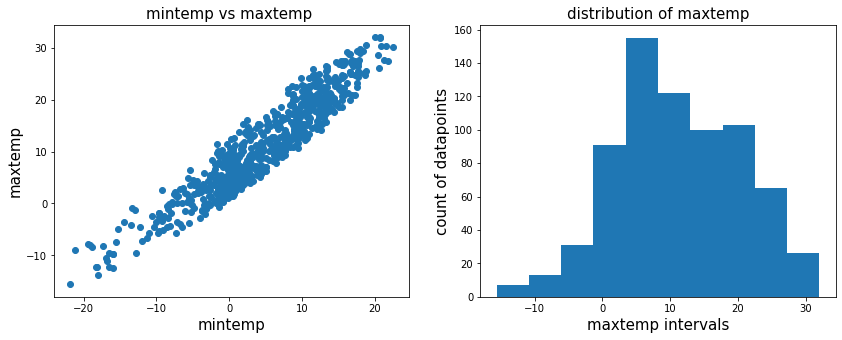

In [10]:
# Visualize data
fig, axes = plt.subplots(1, 2, figsize=(14,5)) # create a figure with two axes (1 row,2 columns) on it
axes[0].scatter(data['MinTemp'],data['MaxTemp']) # plot a scatter plot on axes[0] to show the relation between MinTemp and MaxTemp
axes[0].set_xlabel("mintemp",size=15)
axes[0].set_ylabel("maxtemp",size=15)
axes[0].set_title("mintemp vs maxtemp ",size=15)

axes[1].hist(data['MaxTemp']) # plot a hist plot to show the distribution of MaxTemp
axes[1].set_title('distribution of maxtemp',size=15)
axes[1].set_ylabel("count of datapoints",size=15)
axes[1].set_xlabel("maxtemp intervals",size=15)
plt.show()

<div class=" alert alert-warning">

# Student Task A2.2

Consider the dataset that we have loaded in the previous Student Task A2.1. We have stored the feature values and label values of the datapoints in the numpy array `X` and `y`, respectively. This task requires you to learn a linear map $h(x) = w_{0} + w_{1}x$ that allows to predict the label of datapoint based on its feature. To this end we will use the numpy arrays `X` and `y` from the previous task as a training set. 

The class [`LinearRegression()`](https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LinearRegression.html#sklearn.linear_model.LinearRegression) provides methods to search for optimal weights $w_{0}$ and $w_{1}$ from a linear hypothesis space: $$
\mathcal{H}^{(n)}_{\rm linear} := \big\{ h: \mathbb{R} \mapsto \mathbb{R} : h({\bf x}) = \mathbf{w}^T\mathbf{x} 
=
\begin{bmatrix} w_0 & w_1 \end{bmatrix}
\begin{bmatrix} 1 \\ x \end{bmatrix}
= w_0\cdot 1 + w_1x,\  w_{0},w_{1} \in \mathbb{R} \big\},
$$such that the resulting average squared error loss on a given set of datapoints is minimal. In particular, the method [LinearRegression.fit()](https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LinearRegression.html#sklearn.linear_model.LinearRegression.fit) solves the optimization (training) problem 
   $$ \min_{w_{1},w_{0} \in \mathbb{R}} (1/m)\sum_{i=1}^{m} \big (y^{(i)} - \underbrace{\big( w_{0} + w_{1} x^{(i)} \big)}_{=h\big(x^{(i)}\big)} \big)^{2}$$
    
<strong><i><u>Your task<i></u></strong> is to use the `LinearRegression.fit()` method to find the optimal parameters $w_{0}$ and $w_{1}$ and then compute the resulting predicted labels $\hat{y}^{(i)}$ using the feature values in `X` (the features from the training set). You can use the method `LinearRegression.predict()` for computing the predicted labels. The predicted labels should be stored in the one-dimensional `numpy` array `y_pred` which has the same shape as `y` (from the previous student task). Based on the predicted labels you should also calculate the resulting training error $$(1/m) \sum_{i=1}^{m} \big(\hat{y}^{(i)} - y^{(i)} \big)^2.$$
    
Hints: you might find the function [mean_squared_error()](https://scikit-learn.org/stable/modules/model_evaluation.html#mean-squared-error) useful for computing the training error. 
</div>

In [11]:
## 1. Fit a linear regression model
# regr = ...
# regr.fit(...)

## 2.Predict label values based on features and calculate the training error
# y_pred = ...   
# tr_error = ...

# YOUR CODE HERE
#1. Fit a linear regression model
regr = LinearRegression()
regr.fit(X, y)

## 2.Predict label values based on features and calculate the training error
y_pred = regr.predict(X)   
tr_error = mean_squared_error(y_pred,y)

print('The training error is: ', tr_error)    # print the training error
print("w1 = ", regr.coef_)   # print the learnt w1
print("w0 = ",regr.intercept_) # print the learnt w0

The training error is:  9.969818232805473
w1 =  [1.06990194]
w0 =  6.207368376556124


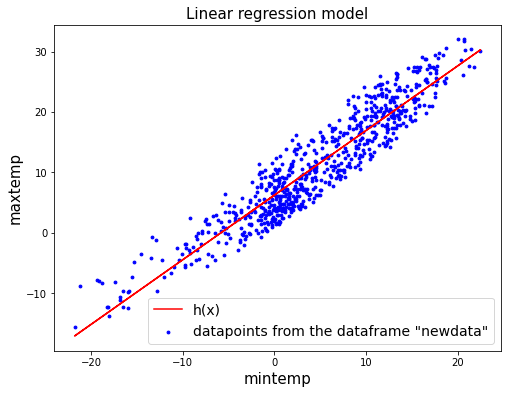

In [12]:
## visualize the model you have learnt, you are supposed to see the datapoints and the fitted h(x), a straignt line

plt.figure(figsize=(8, 6))    # create a new figure with size 8*6

# create a scatter plot of datapoints 
# each datapoint is depicted by a dot in color 'blue' and size '10'
plt.scatter(X, y, color='b', s=8, label='datapoints from the dataframe "newdata"') 

# plot the predictions obtained by the learnt linear hypothesis using color 'red' and label the curve as "h(x)"
y_pred = regr.predict(X)    # predict using the linear model
plt.plot(X, y_pred, color='r', label='h(x)')  

plt.xlabel('mintemp',size=15) # define label for the horizontal axis 
plt.ylabel('maxtemp',size=15) # define label for the vertical axis 

plt.title('Linear regression model',size=15) # define the title of the plot   
plt.legend(loc='best',fontsize=14) # define the location of the legend  

plt.show()  # display the plot on the screen 


In [13]:
# this cell is for tests


<div class=" alert alert-warning">

# Student Task A2.3
    
Consider datapoints with a single numeric feature $x$ and numeric label $y$. When the relation $x \mapsto y$ between feature $x$ and label $y$ is non-linear, it might be useful to use a hypothesis space which is constituted by non-linear maps (a non-linear model). 

One basic, yet very useful, non-linear model is constituted by polynomials of given (maximum) degree n,
$$
\mathcal{H}^{(n)}_{\rm poly} = \big\{ h: \mathbb{R} \mapsto \mathbb{R} : h(x)
=
\begin{bmatrix} w_0 & w_1 & \cdots & w_{n} \end{bmatrix}
\begin{bmatrix} 1 \\ x \\ \vdots \\ x^{n} \end{bmatrix}
=
\sum_{l=0}^{n} w_{l} x^{l},\  w_{0},\ldots,w_{n} \in \mathbb{R} \big\}.
$$
It is obvious that if we set the degree $n$ of a polynomial hypothesis to 1, then this polynomial hypothesis boils down to a linear hypothesis.

We then learn the weights of the polynomial to minimize the average loss of the hypothesis on a training set. 

Instead of designing a new algorithm for optimizing the parameters of the polynomial we will re-use the algorithm for linear regression. The idea is to represent a polynomial as the concatentation of a feature map (transformation) and a linear map (which are used in linear regression). 

Any polynomial predictor $h(x) \in \mathcal{H}^{(n)}_{poly}$ is the concatenation of the feature map
\begin{equation}
x\mapsto \phi(x) := \underbrace{\big(1, x, ..., x^n\big)^T}_{\text{ new feature vector $\mathbf{x}$}} \in \mathbb{R}^{n+1}
\end{equation}
with some linear map $\tilde{h}:\mathbb{R}^{n+1} \rightarrow \mathbb{R}:x \mapsto \mathbf{w}^T \phi(x)$, i.e.,
\begin{equation}
h(x)=\tilde{h}(\phi(x))
\end{equation}

Thus, we can implement polynomial regression by a two-step procedure: 

* Step 1: Consider a set of $m$ datapoints (the training set). Each datapoint is characterized by a feature $x^{(i)}$. From this feature, compute the feature vector 
\begin{equation}
\mathbf{x}^{(i)}=\phi(x^{(i)})=(1, x^{(i)}, ..., (x^{(i)})^{n})^T \in \mathbb{R}^{n+1}. 
\end{equation}
Stack these feature vectors into a feature matrix $\mathbf{X} = \big(\mathbf{x}^{(1)},\ldots,\mathbf{x}^{(m)}\big)$. 

* Step 2: We then apply linear regression to the features in $\mathbf{X}$. 

<strong><i><u>Your task<i></u></strong> is to use the same feature `X` and label `y` in Task 2.2 to fit polynomial regression models with varying degrees d=3, 5, 10. The `scikit-learn` class [`PolynomialFeatures()`](https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.PolynomialFeatures.html?highlight=polynomial#sklearn.preprocessing.PolynomialFeatures) allows to construct polynomial features via generating powers of a scalar feature. The method `PolynomialFeatures.fit_transform()` is for fitting and transforming the raw features. The classes of linear regression and training loss are the same as in task A2.2.

</div>

Polynomial degree =  3
The first two row of X_poly: 
 [[  1.     -2.6     6.76  -17.576]
 [  1.      1.8     3.24    5.832]]

The learned wegihts: 
 [ 5.66167983e+00  1.04645213e+00  8.75902040e-03 -1.27473569e-04]


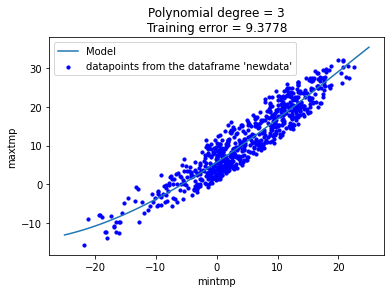

Polynomial degree =  5
The first two row of X_poly: 
 [[   1.        -2.6        6.76     -17.576     45.6976  -118.81376]
 [   1.         1.8        3.24       5.832     10.4976    18.89568]]

The learned wegihts: 
 [ 5.54138025e+00  1.00038517e+00  1.50842415e-02  1.43485632e-04
 -2.02506416e-05 -3.35108778e-07]


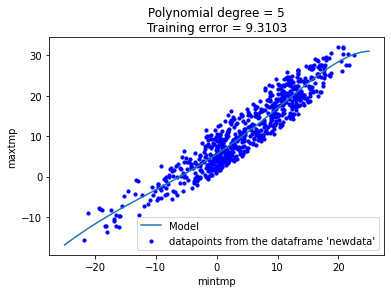

Polynomial degree =  10
The first two row of X_poly: 
 [[ 1.00000000e+00 -2.60000000e+00  6.76000000e+00 -1.75760000e+01
   4.56976000e+01 -1.18813760e+02  3.08915776e+02 -8.03181018e+02
   2.08827065e+03 -5.42950368e+03  1.41167096e+04]
 [ 1.00000000e+00  1.80000000e+00  3.24000000e+00  5.83200000e+00
   1.04976000e+01  1.88956800e+01  3.40122240e+01  6.12220032e+01
   1.10199606e+02  1.98359290e+02  3.57046723e+02]]

The learned wegihts: 
 [ 5.39495693e+00  9.57799509e-01  2.88888296e-02  6.66254676e-04
 -9.71746889e-05 -1.08726506e-06 -4.27934547e-07 -2.93917380e-09
  2.82295487e-09  5.31485619e-12 -3.58846286e-12]


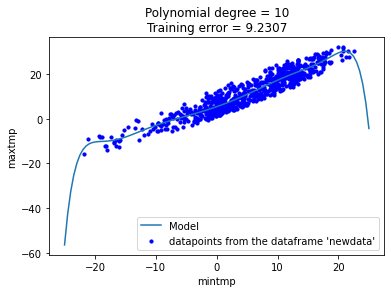

In [24]:
## define a list of values for polynomial degrees 
degrees = [3, 5,10]    

# declare a variable to store the resulting training errors for each polynomial degree
tr_errors = []          

for i in range(len(degrees)):    # use for-loop to fit polynomial regression models with different degrees
    
    print("Polynomial degree = ",degrees[i])

    # YOUR CODE HERE
    poly = PolynomialFeatures(degree = degrees[i])    # initialize a polynomial feature transformer 
    X_poly = poly.fit_transform(X)    # fit and transform the raw features
    
    lin_regr = LinearRegression(fit_intercept=False) # NOTE: "fit_intercept=False" as we already have a constant iterm in the new feature X_poly
    lin_regr.fit(X_poly,y)    # fit linear regression to these new features and labels (labels remain same)
    
    y_pred = lin_regr.predict(X_poly)     # predict using the learnt linear model
    tr_error = mean_squared_error(y_pred,y)    # calculate the training error
    
    # sanity check the feature matrix is transformed correctly
    assert X_poly.shape == (X.shape[0],degrees[i]+1), "Wrong polynomial degree" 
    
    print("The first two row of X_poly: \n",X_poly[0:2])
    
    print("\nThe learned wegihts: \n",lin_regr.coef_)
    
    tr_errors.append(tr_error)
    X_fit = np.linspace(-25, 25, 100)    # generate samples
    plt.plot(X_fit, lin_regr.predict(poly.transform(X_fit.reshape(-1, 1))), label="Model")    # plot the polynomial regression model
    plt.scatter(X, y, color="b", s=10, label="datapoints from the dataframe 'newdata'")    # plot a scatter plot of y(maxtmp) vs. X(mintmp) with color 'blue' and size '10'
    plt.xlabel('mintmp')    # set the label for the x/y-axis
    plt.ylabel('maxtmp')
    plt.legend(loc="best")    # set the location of the legend
    plt.title('Polynomial degree = {}\nTraining error = {:.5}'.format(degrees[i], tr_error))    # set the title
    plt.show()    # show the plot

# sanity check 
assert len(tr_errors) == 3 # check the length of array tr_errors

In [ ]:
# this cell is for tests


<div class=" alert alert-warning">
    
# Student Task A2.4

This task requires you to study the effect of using different amount of training data for a fixed model. We will use polynomial regression with fixed degree 5. We will learn the parameters of the polynomial using a varying amount of datapoints from the dataset as the training set. 

</div>


Number of datapoints in this subset:  71


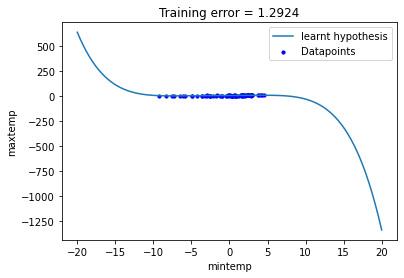


Number of datapoints in this subset:  285


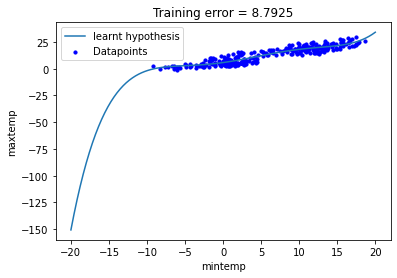


Number of datapoints in this subset:  427


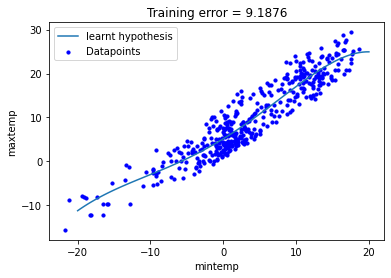

In [22]:
trainingset_size = [0.1, 0.4, 0.6]    # set the different sizes of training set
degree = 5                          # set the degree
tr_errors = []                      # store training errors

for i in range(len(trainingset_size)):    # use for-loop to fit polynomial regression models with different sizes of training set
    index = np.arange(int(len(X)*trainingset_size[i]))
    print("\nNumber of datapoints in this subset: ",len(index))

    X_sub = X[index]    # obtain a subset, NOTE: this is the subset of features you will use for this task
    y_sub = y[index]    # NOTE: this is the subset of labels you will use for this task

    # YOUR CODE HERE
    poly = PolynomialFeatures(degree)    # initialize a polynomial feature transformer 
    X_poly = poly.fit_transform(X_sub)    # fit and transform the raw features, i.e. X_sub
    
    lin_regr = LinearRegression(fit_intercept=False) # NOTE: "fit_intercept=False" as we already have a constant iterm in the new feature X_poly
    lin_regr.fit(X_poly,y_sub)    # fit linear regression to these new polynomial features and labels
    
    y_pred = lin_regr.predict(X_poly)    # predict using the learnt linear model
    tr_error = mean_squared_error(y_pred,y_sub)    # calculate the training error

    
    tr_errors.append(tr_error)
    X_fit = np.linspace(-20, 20, 100)    # generate samples
    plt.plot(X_fit, lin_regr.predict(poly.transform(X_fit.reshape(-1, 1))), label="learnt hypothesis")        # plot the polynomial regression model
    plt.scatter(X_sub, y_sub, color="b", s=10, label="Datapoints ")    # plot a scatter plot of y(maxtmp) vs. X(mintmp) with color 'blue' and size '10'
    plt.xlabel('mintemp')    # set the label for the x/y-axis
    plt.ylabel('maxtemp')
    plt.legend(loc="best")    # set the location of the legend
    plt.title('Training error = {:.5}'.format(tr_error))    # set the title
    plt.show()    # show the plot
    
# sanity check
assert X_poly.shape[1] == 6, "Wrong dimension, you should use degree=5 for PolynomialFeatures() "
assert len(tr_errors) == 3 # check the shape of the array tr_errors
assert np.isclose(tr_error,9.18756), "Incorrect training error, you might be using a wrong training set"

In [ ]:
# this cell is for tests


<div class=" alert alert-info" >

# Demo: Huber regression  
    
**Huber regression** is a ML method that offers robustness against outliers in the training set. These outliers are "abnormal" datapoints which might arise due to hardware failures. Similar to linear regression, also Huber regression learns a linear hypothesis map. However, in contrast to linear regression (which uses the squared error loss), Huber regression uses the Huber loss
$$
L((x,y),h)=\begin{cases}
\frac{1}{2}(y-h(x))^2 &\text{if $|y-h(x)|\leq\delta$}\\
\delta(|y-h(x)|-\delta/2) & \text{otherwise}.\\
\end{cases}
$$
    
This equation is telling us: for (absolute) loss values less than $\delta$ use MSE, for (absolute) loss values larger than $\delta$ use MAE, because MSE has the tendency to be dominated by outliers, but MAE will treat all loss values on the same linear scale.
    
<img src="loss_functions.png" width="400" height="200"/>

We can use the class [`HuberRegressor`](https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.HuberRegressor.html?highlight=huber#sklearn.linear_model.HuberRegressor) in `sklearn.linear_model` to implement linear regression with Huber loss.

The example below concretely shows that linear regression is strongly influenced by the outliers present in the dataset. The Huber regressor is less influenced by the outliers. 
</div>    

In [19]:
np.random.seed(42)    # set the random seed
X_ = X[0:50,:].copy()
y_ = y[0:50].copy()
y_noise = y[0:50].copy()    # copy the labels y
outliers = [i for i in range(len(X_)) if X_[i] < -7] #index of outliers
for j in outliers:    # use a for-loop to obtain outliers
    y_noise[j] = y[j] + np.random.normal(-2,1)*5 # simulate some outliers by adding a random noise

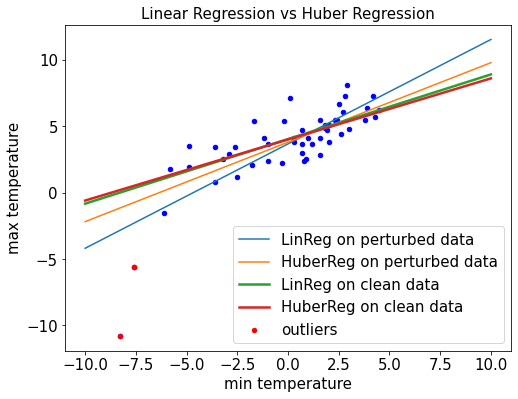

In [20]:
models = {'LinReg': LinearRegression(), 'HuberReg': HuberRegressor()}    # set the different regression models

figure = plt.figure(figsize=(8, 6))    # create a figure of size 8*6
for key in models:    # use a for-loop to fit regression models with different losses
    model = models[key].fit(X_, y_noise)  
    X_fit = np.linspace(-10, 10, 100)    # generate samples
    plt.plot(X_fit, model.predict(X_fit.reshape(-1, 1)), label=key+' on perturbed data')    # plot the specific regression model

Lmodel = LinearRegression().fit(X_, y_)    # apply linear regression model to the features and labels without perturbation
plt.plot(X_fit, Lmodel.predict(X_fit.reshape(-1, 1)),linewidth=2.5, label='LinReg on clean data')    # plot the regression model without perturbation

Hmodel = HuberRegressor().fit(X_, y_)    # apply linear regression model to the features and labels without perturbation
plt.plot(X_fit, Hmodel.predict(X_fit.reshape(-1, 1)), linewidth=2.5, label='HuberReg on clean data')    # plot the regression model without perturbation

plt.scatter(X_[:,0], y_noise, color="b", s=20) # plot datapoints with color 'blue'
plt.scatter(X_[outliers], y_noise[outliers], color="r", s=20,label='outliers') # plot outliers with color 'red'
plt.xlabel('min temperature',fontsize=15)    # set the label for the x/y-axis
plt.ylabel('max temperature',fontsize=15)
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)
plt.legend(loc="best",fontsize=15)    # set the location of the legend
plt.title('Linear Regression vs Huber Regression',fontsize=15)    # set the title
plt.show()    # show the plot

<div class=" alert alert-warning">

# Student Task A2.5 

Answer the following quiz questions by setting the corresponding variable to the index of the answer that you consider correct. 
    
Question 1: What is the effect of using larger models, such as polynomials with larger degree, on the resulting training error for a given training set? 
- Answer 1: The training error always increases with increasing model size (polynomial degree). 
- Answer 2: The training error typically decreases with increasing model size (polynomial degree). 

Question 2: What is the effect of using larger training sets to train a given model (such as a polynomials with degree 3)?
- Answer 1: The training error might sometimes increase with increasing size of training set. 
- Answer 2: The training error will never increase with increasing size of training set.  
    
Question 3: What is the effect of using the Huber loss instead of squared error loss when learning a linear hypothesis map?
- Answer 1: The learnt hypothesis does not change significantly in the presence of few outliers.  
- Answer 2: For $\delta > 1$, the Huber loss is always larger than squared error loss.  
 

</div>

In [27]:

## set Answer_Q1 to the index of the correct answer (e.g., Answer_Q1=1 if you think Answer 1 is correct)

Answer_Q1  = 1  

## set Answer_Q2 to the index of the correct answer for Question 2 

Answer_Q2 = 1   

## set Answer_Q3 to the index of the correct answer for Question 3 

Answer_Q3 = 2 

# YOUR CODE HERE

# sanity check datatype of Answer_Q1
assert isinstance(Answer_Q1, int), "Please use datatype 'int' for your answer"

In [ ]:
# this cell is for tests